<a href="https://colab.research.google.com/github/amanrana21711/MRI_SCAN_CNN/blob/main/Forest_Cover_UB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
'''I have uploaded the train.csv file in my drive. So i will import it from there'''
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
#Reading the training data through pd
data = pd.read_csv('/content/drive/MyDrive/train.csv')

data["Cover_Type"] = data['Cover_Type'].map({1:0,2:1,3:2,4:3,5:4,6:5,7:6})

x = data.drop('Cover_Type',axis=1).values
y = data['Cover_Type'].values



data


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,4
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,4
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,1
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,1
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,...,0,0,0,0,0,0,0,0,0,2
15116,15117,2603,121,19,633,195,618,249,221,91,...,0,0,0,0,0,0,0,0,0,2
15117,15118,2492,134,25,365,117,335,250,220,83,...,0,0,0,0,0,0,0,0,0,2
15118,15119,2487,167,28,218,101,242,229,237,119,...,0,0,0,0,0,0,0,0,0,2


In [6]:
#Splitting the data in 80,20 for train and testing

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=41)

#Creating Tensors
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

tensor_ds = TensorDataset(x_train,y_train)
tensor_dl = DataLoader(tensor_ds,batch_size=64,shuffle = True, pin_memory=True,num_workers=4)


In [9]:
#Model
class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(55,102)
    self.act1 = torch.nn.LeakyReLU()
    self.linear2 = nn.Linear(102,55)
    self.act2 = torch.nn.LeakyReLU()
    self.linear3 = nn.Linear(55,7)

  def forward(self,x):
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)

    return x


model = NN()
model = model.to(device)

loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=0.0003)

#two list to keep track of epochs and loss for later ploting
noe = []
loss_list = []


In [10]:
#Training
for epoch in range(1000):
  for xb,yb in tensor_dl:
    xb = xb.to(device)
    yb = yb.to(device)

    pred = model(xb)
    error = loss(pred,yb)
    error.backward()

    opt.step()
    opt.zero_grad()


  loss_list.append(error)

  noe.append(epoch)

  if epoch%100 ==99:
    print(error.item())

0.4012977182865143
0.33032867312431335
0.1678803563117981
0.2640465497970581
0.07146371901035309
0.07477356493473053
0.16208229959011078
0.036117009818553925
0.06237540766596794
0.041933007538318634


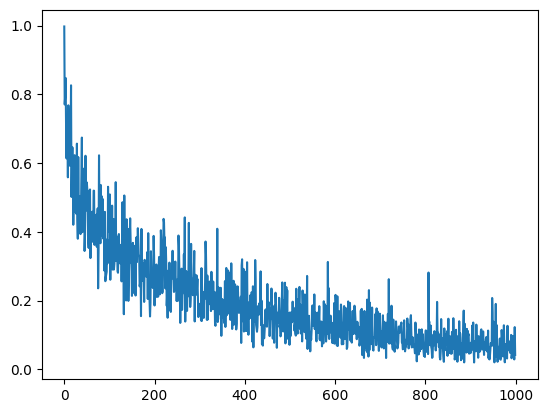

In [12]:
import matplotlib.pyplot as plt

el = [i for i in range(len(loss_list))]

dummy = []
for i in loss_list:
  dummy.append(i.item())

plt.plot(el,dummy)

In [13]:
preds = model(x_test)
preds_new = torch.argmax(preds,dim=1)

correct = 0
incorrect = 0

for i in range(len(preds_new)):
  if preds_new[i] == y_test[i]:
    correct += 1
  else:
    incorrect += 1

total = correct+incorrect
print(correct,incorrect,total)

2553 471 3024


In [ ]:
'''
Conclusion accuracy is low as per my expectation. But due to less compute units on colab i am restricted to less epochs
and experimenting on different Lossfunctions and optimizers. I am thinking of Mean Absolute as the loss function to try out
but again i am stuck with less compute units.
Also less number of epochs because in this too it took a lot of time on normal colab cpu.
I can implement a scheduler in this to increase overall accuracy too.
2-3 ideas which i can implement after testing and training i have left out. Overall good performance.

Thank You
Aman
'''

#edit i added this scalar to bring the values close to zero and it has up the accuracy a bit

/bin/bash: line 1: https://github.com/amanrana21711/Forest_Cover_UB.git: No such file or directory
